<a href="https://colab.research.google.com/github/adeiltonmsantos/DataHandler/blob/main/DataHandler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

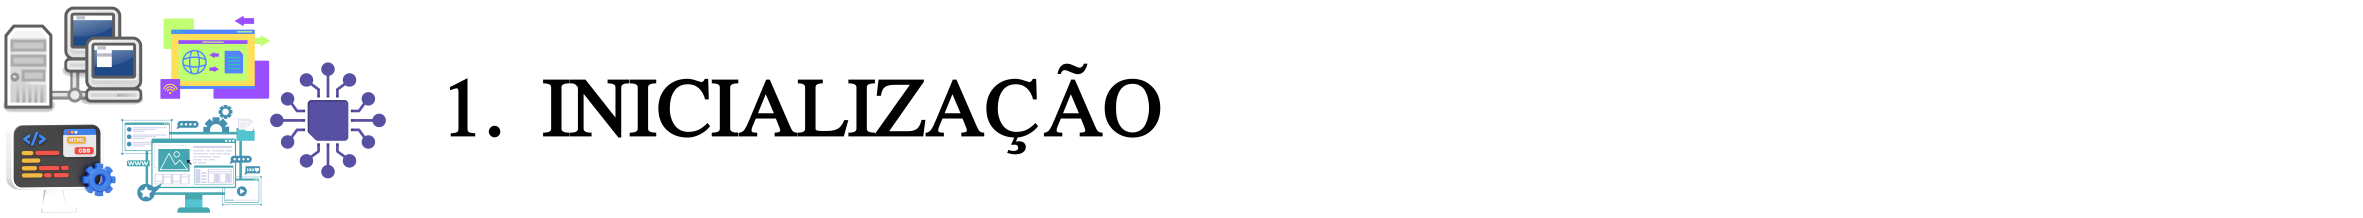

Este bloco de código deve ser executado para que a aplicação funcione. Serão carregadas todas as bibliotecas necessárias e será solicitado o acesso à sua conta Google Drive

In [12]:
# @title Clique no botão PLAY abaixo para carregar as bibliotecas e dar acesso ao seu Google Drive

print('-------------------------------')
print('           AGUARDE ...')
print('-------------------------------')

# Instalação de bibliotecas
!pip install -q pdfplumber
!pip install -q fpdf2
!pip install -q google-generativeai
!pip install -q google.ai.generativelanguage

# Importação de bibliotecas
import pdfplumber
from fpdf import FPDF
import pandas as pd
import os
import json
import datetime as dt
import shutil as sh
import ast
from google.colab import drive, files
import google.generativeai as genai
from google.ai.generativelanguage_v1beta.types import content
from IPython.display import clear_output, HTML
import time
import urllib
from PIL import Image
import matplotlib.pyplot as plt

clear_output()

# Classe para exibir pequenos splashs dos tipos 'info', 'sucess' e 'fail'
class Splash():
  def __init__(self):
    self.align = 'center'
    self.width = 200

    self.css_info = 'border: 1px solid black; background-color: #ffff80; '
    self.css_info += 'font-weight: bold; text-align: {}; width: {}px'
    self.css_info += '; padding: 8px'

    self.css_fail = 'border: 1px solid black; background-color: red; color:white'
    self.css_fail += '; font-weight: bold; font-size: 13pt; text-align: {}; '
    self.css_fail += 'width: {}px; padding: 8px'

    self.css_sucess = 'border: 1px solid black; background-color: #00ff99; '
    self.css_sucess += 'font-weight: bold; text-align: {}; width: {}px; '
    self.css_sucess += 'padding: 8px'

    self.div = '<div style="{}; font-size: {}"><div style="padding: 12px">{}</div></div>'

  def renderSplash(self, msg, tipo='sucess', delay=3, width=200, align='center', font_size=13):
    clear_output()
    if tipo == 'fail':
      self.css_fail = self.css_fail.format(align, width)
      display(HTML(self.div.format(self.css_fail, font_size, msg)))
    elif tipo == 'sucess':
      self.css_sucess = self.css_sucess.format(align, width)
      display(HTML(self.div.format(self.css_sucess, font_size, msg)))
    elif tipo == 'info':
      self.css_info = self.css_info.format(align, width)
      display(HTML(self.div.format(self.css_info, font_size, msg)))

    if delay > 0:
      time.sleep(delay)
      clear_output()

# Instanciando objeto Splash para ser usado em qualquer bloco de código abaixo
splash = Splash()

splash.renderSplash('&nbsp;&nbsp;&nbsp;Carregando bibliotecas...&nbsp;&nbsp;&nbsp;', 'info', width=400, delay=0)

class PDF(FPDF):
  def __init__(self):
    super().__init__()
    self.add_page()
    self.set_font('Helvetica', '', 10)
    self.set_margins(20, 20, 20)
    self.set_xy(20,20)

  # Retorna o limite vertical para quebra de página
  def get_max_y(self):
    return self.h - self.t_margin - self.b_margin

  # Retorna o limite horizontal para ultrapassar margem direita
  def get_max_x(self):
    return self.w - 2 * self.l_margin

  # Renderiza uma imagem no PDF e coloca o cursor abaixo dela
  def renderImage(self, filename, prop_w=None, align=None, y_adic_new_page=None):
    """ image(filename, dim, dim_vl): Define uma imagem no PDF e coloca o cursor abaixo dela.
        O tamanho da imagem deve ser definido em relação à largura da página. O parâmetro
        'prop_w' é um valor entre 0 e 100 que corresponde ao percentual da largura da página
        que a imagem deve ocupar. Sua altura é automaticamente definida com base na proporção
        entre altura e largura da própria imagem

    Args:
      - filename (obrigatório): Nome do arquivo da imagem
      - prop_w (opcional): valor entre 0 e 100 que corresponde ao percentual da largura da
                         página que a imagem deve ocupar. Sua altura é automaticamente
                         definida com base na proporção entre altura e largura da própria
                         imagem. Se não for informado, usa 100% da largura da página
      - align (opcional): alinhamento da imagem que pode ser 'C', 'L' ou 'R'. Se não for
                          informado alinha ao centro
      - y_adic_new_page (opcional): incremento para a posição vertical, caso a imagem
                                    ultrapasse a margem inferior da página e seja
                                    renderizada na próxima página
    """

    y = self.get_y()

    # Para obter as dimensõres reais da imagem em pixels
    img = Image.open(filename)

    # Capturando as dimensões da imagem
    W_img, H_img = img.size

    # Razão entre largura e altura
    W_H = W_img/H_img

    # Largura da página descontando as margens
    W_pg = self.w - self.l_margin - self.r_margin

    # Altura da página descontando as margens
    H_pg = self.get_max_y() - self.t_margin

    # Dimensões da imagem em milímetros
    if prop_w is None:
      prop_w = 100
    W_img = W_pg * prop_w / 100
    H_img = W_img / W_H

    # Se a base da imagem ultrapassar a margem inferior, quebra a página
    # Posição y da base da imagem na página
    Y = y + H_img
    # Coordenada y que é o limite para ultrapassar a margem inferior
    Y_lim = self.h - self.b_margin
    if Y > Y_lim:
      self.add_page()
      y = self.t_margin if y_adic_new_page is None else y_adic_new_page + self.t_margin


    # Posicionando o cursor de acordo com o parâmetro 'align'
    match align:
      case 'L':
        x_img = self.l_margin
      case 'R':
        x_img = self.w - self.r_margin - W_img
      case 'C':
        x_img = self.l_margin + (self.w - self.l_margin - self.r_margin - W_img) / 2
      case _:
        x_img = self.l_margin + (self.w - self.l_margin - self.r_margin - W_img) / 2
        self.set_x(x_img)

    # Renderizando a imagem de acordo com a largura
    self.image(filename, w=W_img, y=y, x=x_img)

    # Posicionando o cursor abaixo da imagem
    self.set_y(y + H_img)

  def cellBreakLine(self, txt, w, h):
    """
    Verifica se o texto 'txt' deve quebrar página ao ser renderizado em uma célula
    com multi_cell(). Retorna True se deve quebrar página ou False caso contrário

    Argumentos:
    - txt: o texto ou string a ser renderizado
    - w: largura da célula
    - h: altura da célula
    """

    # Posição vertical inicial
    y_0 = self.get_y()

    # Limite vertical para quebra de página (altura total da folha menos a margem
    # inferior)
    y_max = self.h - self.b_margin #self.get_max_y()

    # Lista com o conteúdo do texto em linhas
    lines = []

    # String com a linha atual
    line_current = ''

    # Quebrando o texto em uma lista de palavras
    words = str(txt).split()

    for word in words:
      # Adiciona à linha atual mais uma palavra do texto se não exceder a
      # largura da célula
      if self.get_string_width(line_current + ' ' + word) < w:
        line_current += ' ' + word
      # Excedeu a largura da célula. Adiciona a linha atual à lista de linhas e
      # a palavra excedente é atribuída à nova linha atual
      else:
        lines.append(line_current)
        line_current = word

    # Após o loop, caso a última palavra não tenha excedido a largura da linha
    # adcionando a última linha atual à lista de linhas
    lines.append(line_current)

    # Calculando o número de linhas. É adicionado um incremento de 1 por segurança
    num_lines = len(lines) + 1
    height_cell = num_lines * h

    # Calculando a posição y referente à base da célula
    y = y_0 + height_cell

    # Retorna True se deve quebrar linha (se y atual for maior que y_max), False
    # caso contrário
    return y > y_max


  def rowBreakLine(self, row, cols_w, h):
    """
    Verifica se a lista com strings 'row' ao ser renderizada com 'renderRowTable()'
    deve quebrar página. Retorna True se deve quebrar página ou False caso contrário

    Argumentos:
    - row: lista com as strings de cada célula
    - cols_w: lista com as larguras das colunas em mm.
    - h: altura de uma linha sem quebra de linha
    """
    for i in range(len(row)):
      if self.cellBreakLine(row[i], cols_w[i], h):
        return True
    return False

  def renderRowTable(self, row, cols_w=[], h=5, cabec=False):
    """
    Renderiza uma linha de tabela dados os valores de cada célula em uma lista

    Argumentos:
    - row: iterável com os valores de cada célula
    - cols_w: lista com as larguras das colunas em mm. Se não for fornecido,
    divide a largura últil da página por igual entre as colunas
    - h: altura da linha. Usa 5 mm se não for informado
    """

    # Lista com as larguras das colunas não informadas. Distribui por igual
    if cols_w == [] or len(cols_w) < len(row):
      w_pg = self.w - self.l_margin - self.r_margin
      cols_w = [] # Resetando a lista caso tenha sido informada com tamanho diferente de row
      for i in range(len(row)):
        cols_w.append(w_pg/len(row))

    # A linha é o cabeçalho da tabela. Fonte será em negrito
    if cabec:
      self.set_font('helvetica', 'B')

    # Posição vertical inicial
    y_0 = self.get_y()

    # Posição vertical da base de qualquer célula
    y = None

    # Altura provisória da linha
    h_temp = 0

    # Altura definitiva da linha
    h_efet = 0

    # Posição horizontal antes de se fazer qualquer coisa
    x_0 = self.get_x()

    # Posição horizontal de qualquer célula
    x = x_0

    # Renderizando a linha com tudo transparente para determinar a altura
    # efetiva da linha
    self.set_text_color(255)
    for i in range(len(row)):
      self.set_xy(x, y_0)
      self.multi_cell(cols_w[i], h, str(row[i]), border=0, align='J')
      x += cols_w[i]
      y_atual = self.get_y()
      h_temp = y_atual - y_0
      if h_efet < h_temp:
        h_efet = h_temp

    # Renderizando em definitivo apenas o texto, sem as bordas
    self.set_text_color(0)
    x = x_0
    for i in range(len(row)):
      self.set_xy(x, y_0)
      self.multi_cell(cols_w[i], h, str(row[i]), border=0, align='J')
      x += cols_w[i]

    # Renderizando em definitivo as bordas com a altura calculada
    x = x_0
    for i in range(len(row)):
      self.set_xy(x, y_0)
      self.multi_cell(cols_w[i], h_efet, '', border=1)
      x += cols_w[i]

    self.set_font('helvetica', '')
    self.set_xy(x_0, y_0 + h_efet)

  # Renderiza uma tabela a partir de uma DataFrame Pandas
  def renderTableFromPandas(self, df, options={}):
    """ renderTableFromPandas(df, options): Renderiza uma tabela a partir de uma DataFrame Pandas.

    Args:
      df: DataFrame Pandas com os dados da tabela
      options: Dicionário com os parâmetros da tabela

        As seguintes chaves devem ser informadas no dicionário options:

        'h' (obrigatório): altura mínima de cada linha (caso não haja quebra de linha)
        'cols' (obrigatório): lista com os nomes das colunas selecionadas de 'df'
        'tbl_w_per' (optional): largura da tabela em percentual da largura da página
        'labels' (optinal): lista com os rótulos da tabela. Se não for informado usa 'cols'
        'cols_w' (optional): lista com as larguras das colunas em % da largura da tabela. Usa 100% se não for informado
        'align' (opcional): alinhamento da tabela. Pode ser 'L', 'C' ou 'R'. Se for omitido, alinha ao centro

    """

    warning = 'Os parâmetros obrigatórios não foram definidos no dicionário "options":'
    warning += ' cols (lista com rótulos das colunas), tbl_w_perc (largura da tabela'
    warning += ' em % da página)'

    # Carregando a altura mínima das linhas da tabela
    h = options.get('h', 5)

    # Carregando lista com as colunas que serão usadas do DataFrame 'df'
    cols = options.get('cols', None)
    # Não foram definidas as colunas. Usa todas
    if cols is None:
      cols = df.columns

    # Carregando lista com os rótulos da tabela. Se for nula, usa a lista 'cols'
    labels = options.get('labels', cols)

    # Carregando a largura percentual da tabela em relação à largura da página
    w_tab = options.get('tbl_w_per', None)

    # Se a largura percentual da tabela for nula, usa 100% da largura da página
    # subtraída das margens laterais
    if w_tab is None:
      w_tab = self.w - self.l_margin - self.r_margin
    else:
      # Largura da tabela em milímetros
      w_tab = (w_tab / 100) * (self.w - self.l_margin - self.r_margin)

    # Definindo a lista com largura das colunas em mm. Se não for definida,
    # distribui por igual
    cols_w = options.get('cols_w', None)
    if cols_w is None:
      w = w_tab / len(cols)
      cols_w = []
      for item in cols:
        cols_w.append(w)
    elif sum(cols_w) != 100:
      raise ValueError('O somatório das larguras das colunas não é igual a 100%')
    else:
      for i in range(len(cols_w)):
        cols_w[i] = (cols_w[i] / 100) * w_tab

    # Extraindo os valores do dataframe para uma lista. Cada registro é uma
    # lista com os valores de cada linha
    df = df.loc[:, cols]
    lista = df.values.tolist()

    # Definindo o alinhamento da tabela
    x = self.get_x()
    y = self.get_y()

    # Renderizando o cabeçalho da tabela
    # Linha vai quebrar página
    if self.rowBreakLine(labels, cols_w, h):
      # Salvando valores das margens antes de adicionar a nova paǵina
      t_magin = self.t_margin
      b_margin = self.b_margin
      l_margin = self.l_margin
      r_margin = self.r_margin
      self.add_page(same=True)
      self.t_margin = t_magin
      self.b_margin = b_margin
      self.l_margin = l_margin
      self.r_margin = r_margin
      self.set_xy(self.l_margin, self.t_margin)
      self.renderRowTable(labels, cols_w, cabec=True)
    # Linha não vai quebrar paǵina
    else:
      self.renderRowTable(labels, cols_w, cabec=True)

    y = self.get_y()

    i = -1
    # Renderizando as linhas da tabela
    for row in lista:
      # Linha vai quebrar página. Adicionando nova página e ajustando margens
      if self.rowBreakLine(row, cols_w, h):
        t_magin = self.t_margin
        b_margin = self.b_margin
        l_margin = self.l_margin
        r_margin = self.r_margin
        self.add_page(same=True)
        self.t_margin = t_magin
        self.b_margin = b_margin
        self.l_margin = l_margin
        self.r_margin = r_margin
        self.set_xy(self.l_margin, self.t_margin)
        self.renderRowTable(labels, cols_w, cabec=True)
      self.renderRowTable(row, cols_w, cabec=False)


class Report(PDF):
  """
  Classe para gerar o PDF com o relatório da análise dos dados.
  """
  def __init__(self):
    # Margens das páginas
    self.t_margin_cabec = 25 # Margem superior com o cabeçalho
    self.b_margin_footer = 25 # Margem inferior com o rodapé
    super().__init__()
    self.l_margin = 15
    self.r_margin = 15
    self.t_margin = 35
    self.b_margin = 25

  # Cria o cabeçalho
  def header(self):
    self.t_margin = self.t_margin_cabec
    self.set_xy(self.l_margin, self.t_margin - 13)
    txt_cabec = 'DataHandler'
    self.set_font('times', 'B', 12)
    self.set_text_color(150)
    self.set_draw_color(150, 150, 150)
    self.set_line_width(0.5)
    self.multi_cell(self.epw, 5, txt_cabec, border='B', align='R', fill=False)
    self.set_xy(self.l_margin, self.t_margin)
    self.set_text_color(0)
    self.t_margin = 30

  def footer(self):
    self.b_margin = self.h - self.b_margin_footer
    self.set_xy(self.l_margin, self.b_margin + 5)
    self.set_font('times', 'B', 10)
    self.set_text_color(150)
    self.set_draw_color(150, 150, 150)
    self.set_line_width(0.5)
    self.multi_cell(0, 4.5, 'Powered by Adeilton M. Santos', border='T', fill=False)
    self.set_x(self.l_margin)
    self.multi_cell(0, 4.5, f'Página {str(self.page_no())} de {{nb}}')

  def get_max_y(self):
    return self.h - self.b_margin


# Definição da classe DataHandler
class DataHandler():
  def __init__(self):

    # Url do projeto no Google Drive
    self.url_project = '/content/drive/MyDrive/Colab Notebooks/DataHandler'

    # Url da subpasta do projeto com dados extraídos e classificados
    self.url_data_analysis = f'{self.url_project}/analysis'

    # Chave de API do Gemini
    self.gemini_api_key = None

    # Modelo de IA do Gemini para classificar produtos por segmento
    # self.gemini_prompt = None

    # Comentário que identifica conjunto de dados
    self.coment = None

    # Nome do IPEM extraído do PDF analisado em 'miningDataInPDF'
    self.ipem = None

    # Dataframe com dados minerados de PDF
    self.df_mined_data = None

    # Dataframe com resultados de exames reprovados obtidos de 'df_mined_data'
    self.df_reprov_data = None

    # Dataframe com total de reprovados por tipo de exame
    self.df_reprov_por_tipo = None

    # Dataframe com os segmentos e seus códigos
    self.df_segmentos = None

    # Dataframe com produtos reprovados classificados por segmento
    self.df_classif_reprov_data = None

    # Data inicial dos dados classificados
    self.date_start = None

    # Data final dos dados classificados
    self.date_end = None

    # Dataframe com segmentos e demais dados para a análise de Pareto
    self.df_pareto = None

    # N.º da linha de 'df_pareto' com 'perc_acum' >= 85% (frequẽncia relativa
    # acumulada de segmentos reprovados)
    self.n_row_85 = None

    # Dataframe com os segmentos mais reprovados até o 85.º percentil e seus
    # produtos típicos
    self.df_segmentos_85 = None

    # Total geral de exames minerados no PDF
    self.total_exames = None

    # Total de exames reprovados
    self.total_reprov = None

    # Modelo de IA Gemini (definido no método 'verifyGeminiAPI')
    self.gemini_model = None

    # Número máximo de registros processados em cada iteração com Gemini
    self.batch_size = 50

    # Tempo em segundos de pausa entre iterações com Gemini
    self.batch_delay = 30

    # Número máximo de tokens
    self.max_tokens = 3000

    # Objeto com alguma exceção levantada
    self.exception = None

    # Tentando conectar ao Google Drive
    try:
      if self.conectDrive():
        print('Conectado à sua conta Google Drive')
        time.sleep(3)
        clear_output()
    except Exception as e:
      print('Algo não permitiu acesso ao Google Drive')
      print('Execute esta célula mais uma vez')
      print(e)

    ########################################################
    ##################### Verificações #####################
    ########################################################

    # Se não existir pasta e subpasta do DataHandler, as cria
    self.verifyMainSystemFolders()

    # Se o notebook 'ipynb' em execução não estiver na pasta do projeto,
    # o mesmo é movido para lá
    self.verifySystemExec()

    # Verifica se todos os itens necessários ao modelo de IA Gemini estão
    # disponíveis
    self.verifyGeminiAPI()

    # Se o JSON com os segmentos não estiver na pasta do projeto, faz o
    # download do GitHub
    self.verifyJSONSegmentos()

  def conectDrive(self):
    try:
      if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive', force_remount=True)
        return True
    except Exception as e:
      return False

  # Verificando se as pastas do sistema existem. Se não existir, cria todas
  def verifyMainSystemFolders(self):
    # Verificando se a pasta principal existe. Cria se não existir
    if not os.path.isdir(self.url_project):
      os.mkdir(self.url_project)

    # Verificando se a pasta de dados analisados existe. Cria se não existir
    if not os.path.isdir(f'{self.url_project}/analysis'):
      os.mkdir(f'{self.url_project}/analysis')

    time.sleep(3)
    clear_output()

  # Verifica se o executável existe na pasta do sistema no Google Drive. Se não
  # existir copia o ipynb em execução para a pasta do sistema
  def verifySystemExec(self):
    self.verifyMainSystemFolders()
    if not os.path.exists(f'{self.url_project}/DataHandler.ipynb'):
      sh.move('/content/drive/MyDrive/Colab Notebooks/DataHandler.ipynb', self.url_project)
    time.sleep(3)
    clear_output()

  # Verificando se chave API e modelo de prompt Gemini existe. Se não existir, cria
  def verifyGeminiAPI(self):
    # Verificando se a chave API Gemini existe. Se não existir, cria
    if not os.path.exists(f'{self.url_project}/gemini-api-key.txt'):
      try:
        msg = 'Você ainda não salvou a chave de API Gemini. Ela é necessária para que'
        msg += '\na aplicação funcione corretamente. Copie sua chave na página do Google'
        msg += '\nAI Studio em https://aistudio.google.com/app/u/1/apikey. Em seguida,'
        msg += '\ndigite ou cole logo abaixo'
        print('--------------------------------------------------------------------------')
        print('                    Chave API Gemini inexistente')
        print('--------------------------------------------------------------------------')
        print(msg)
        print('--------------------------------------------------------------------------')
        self.gemini_api_key = input('Digite ou cole aqui sua chave do API Gemini: ')
        with open(f'{self.url_project}/gemini-api-key.txt', 'w') as f:
          f.write(self.gemini_api_key)
        print('--------------------------------------------------------------------------')
        print('Chave de API Gemini salva com sucesso!')
        print('--------------------------------------------------------------------------')
      except Exception:
        print('Alguma instabilidade na rede não permitiu acesso ao Google Drive')
        print('Execute esta célula mais uma vez')

    # Não existe arquivo com modelo. Fazendo download do gitHub...
    if not os.path.exists(f'{self.url_project}/gemini-model.txt'):
      !wget https://raw.githubusercontent.com/adeiltonmsantos/DataHandler/refs/heads/main/gemini-model.txt /content/
      sh.move('/content/gemini-model.txt', self.url_project)

    # Copiando o modelo para a propriedade 'gemini_prompt'
    with open(f'{self.url_project}/gemini-model.txt', 'r') as f:
      self.gemini_prompt = f.read()

    # Carregando chave de API Gemini
    with open(self.url_project + '/gemini-api-key.txt', 'r') as f:
      genai.configure(api_key=f.read().strip())

    # Definindo parâmetros de configuração do modelo
    generation_config = {
      "temperature": 0.1,
      "top_k": 1,
      "top_p": 0.1,
      "max_output_tokens": self.max_tokens,
      "response_schema": content.Schema(
        type = content.Type.OBJECT,
        properties = {
          "response": content.Schema(
            type = content.Type.STRING,
          ),
        },
      ),
      "response_mime_type": "application/json",
    }

    # Atribuindo os parâmetros de configuração definidos ao modelo
    self.gemini_model = genai.GenerativeModel(
      model_name="gemini-1.5-pro",
      generation_config=generation_config,
      system_instruction=self.gemini_prompt
    )

    time.sleep(3)
    clear_output()

  # Verificando se os arquivos JSON de segmentos existem. Se não existir, cria
  def verifyJSONSegmentos(self):
    filename = ['segmentos.json', 'segmentos_produtos.json']
    url = f'{self.url_project}'

    for item in filename:
      if not os.path.exists(f'{url}/{item}'):
        !wget -q https://github.com/adeiltonmsantos/DataHandler/raw/refs/heads/main/{item} /content/
        sh.move(f'/content/{item}', self.url_project)

    self.df_segmentos = pd.read_json(url + '/segmentos.json')
    self.df_segmentos_produtos = pd.read_json(url + '/segmentos_produtos.json')

  # Extrai dados de PDF para classificar produtos em outro método
  def miningDataInPDF(self, url_pdf):
    """
    miningDataInPDF(url_pdf)
      Dado o caminho de um arquivo PDF com dados de exames (url_pdf), extrai os
      dados de exames reprovados, armazena-os em um dataframe Pandas
      (df_reprov_data) e classifica os dados quanto ao segmento. Por limitações de
      uso da API Gemini, se o número de registros de exames reprovados for
      superior a 500, só utiliza estes 500 primeiros. O método retorna um
      dicionário com os pares chave/valor:

      'result': True se o PDF tiver 500 ou menos registros de exames reprovados e
                False caso contrário
      'laudo': número do último laudo reprovado extraído
      'produto' nome do último produto reprovado extraído

    """

    # Resetando as propriedades para um novo processamento de dados
    self.resetData()

    # Extraindo páginas do PDF
    pgs = pdfplumber.open(url_pdf).pages

    # Tabela temporária para usar no loop
    tb = None

    # DataFrame Pandas temporário para usar no loop com 12 colunas
    df_temp = pd.DataFrame()

    # DataFrame Pandas para todos os dados
    df = pd.DataFrame()

    # Flag para buscar nome do IPEM
    search_ipem_data = True

    # Gerando o DataFrame Pandas para todos os dados
    for pg in pgs:
      tb = pg.extract_table()

      # Extraindo do PDF o nome do IPEM
      if search_ipem_data:

        # Conteúdo da 1.ª linha extraída como dicionário
        lines = pg.extract_text_lines()

        # Iterando o dicionário
        try:
          for item in lines:
            text = item['text'].strip() # Texto da linha atual sem espaços no início e no fim

            # Achou o nome pois tem 'INST' na string
            if 'INST' in text.upper():

              # Tem 'PÁGINA' na string. Quebrando a string e salvando só o nome do IPEM
              if 'PÁGINA' in text.upper():
                self.ipem = text.split('Página')[0].strip()
              # Não tem 'PÁGINA' na string. Ela inteira é o nome do IPEM
              else:
                self.ipem = text
              break
        except Exception:
          self.ipem = 'Nome do IPEM não identificado'

      # Só concatena os dados extraídos se estiverem no formato correto
      try:
        df_temp = pd.DataFrame(tb[3:])
        df = pd.concat([df, df_temp])
      except Exception:
        pass

    # Rotulando as colunas
    df = df.loc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    df.columns = ['laudo', 'data', 'conclusao', 'I', 'M', 'I/M', 'produto', 'tc','marca', 'qn', 'quant', 'aleat']

    # Garantindo que os valores da coluna 'qn' serão strings para executar o
    # método 'query' em seguida
    df['qn'] = df['qn'].astype(str)

    # Criando dataframe com os totais de reprovados por massa, volume,
    # dimensionais e n.º de unidades (df_reprov_por_tipo)
    dfr = df.query('conclusao == "Reprovado"')
    data = {
        'tipo': ['Massa', 'Volume', 'Dimensional', 'N.º Unidades'],
        'quant': [
            len(dfr.query('qn.str.endswith("g")')),
            len(dfr.query('qn.str.endswith("L")')),
            len(dfr.query('qn.str.endswith("m")')),
            len(dfr.query('qn.str.endswith("Un.")'))
        ]
    }

    self.df_reprov_por_tipo = pd.DataFrame(data)
    self.df_reprov_por_tipo.insert(2, 'perc', [0 for i in range(len(self.df_reprov_por_tipo))])
    self.df_reprov_por_tipo['perc'] = round(self.df_reprov_por_tipo['quant'] * 100 / len(dfr), ndigits=0)
    self.df_reprov_por_tipo.sort_values(by='quant', ascending=False, inplace=True)
    self.df_mined_data = df


    # Definindo uma função lambda pra tentar converter os valores da coluna 'data' em datetime
    def convDateTime(str_data):
      # Retirando qualquer espaço vazio do começo e do final da strig
      str_data = str(str_data).strip()
      try:
        d, m, y = str_data.split('/')
        # Formato da data é dd/mm/yy (8 caracteres)
        if len(str_data) == 8:
          return dt.datetime.strptime(str_data, '%d/%m/%y')
        # Formato da data é dd/mm/yyyy
        elif len(str_data) == 10:
          return dt.datetime.strptime(str_data, '%d/%m/%Y')
        # A string deve ser um valor inválido
        else:
          return None
      except Exception as e:
        return None

    # Aplicando a função lambda acima na coluna 'data'
    df['data'] = df['data'].apply(convDateTime)

    # Filtrando o dataframe com valores nulos de 'produto' e 'qn'
    df_problem = df.query('produto.str.len() == 0 or qn.str.len() == 0')

    # Filtrando o dataframe apenas com registros cujos valores de 'produto'
    # (erros do SGI)
    df.query('produto.str.len() > 0', inplace=True)

    # Filtrando o dataframe apenas com registros com 'qn' não nulo (nulos são
    # desiguais e têm valores em 'produto')
    df.query('qn.str.len() > 0', inplace=True)

    # Resetando o index do dataframe
    df.reset_index(drop=True, inplace=True)

    # Atribuinfo o dataframe final à propriedade 'df_mined_data'
    self.df_mined_data = df

    # Filtrando os reprovados para df_reprov_data
    self.df_reprov_data = df.query('conclusao == "Reprovado"')

  def getDictMercadorias(self, df_rp):
    """
    Cria dicionário apenas c/ as colunas 'laudo' e 'produto' do dataframe df_rp
    obtido de 'df_reprov_data' para classificar por segmento
    """

    # Definindo um dataframe chamado 'df' com todos os reprovados
    df = df_rp
    df = df.loc[:, ['laudo', 'produto']]

    # Convertendo os valores de laudo (string) para inteiro (int)
    try:
      df['laudo'] = df['laudo'].apply(lambda x: int(x))
    except Exception:
      pass

    # Retornando a lista de dicionários com os dados
    return df.to_dict('records')


  # Usa a API Gemini para receber um dicionário com número máximo de registros
  # de 'self.batch_size' e estima os segmentos de cada registro
  def getSegmentosFromDicion(self, dicion):
    """
    getSegmentosFromDicion(self, dicion)
      Recebe uma lista cujos elementos são dicionários com de números de
      laudos e nomes de produtos no formato:
      [ {'laudo': '123', 'produto': 'arroz'}, ... ].
      Retorna uma lista com os respectivos números de laudos e código do
      segmento estimado. Ex.:
      [ {'laudo': '123', 'segmento': 2}, ... ].

      Parâmetro:
        dicion: lista de dicionários com números de laudos e nomes de produtos.
        A quantidade de dicionários é limitada ao valor 'batch_size'
    """

    chat_session = self.gemini_model.start_chat(
      history=[
        {
          "role": "user",
          "parts": [
            "[{'laudo': 694375, 'produto': 'CANJICA'}, 'laudo': 694379, 'produto': 'SOPÃO'}]",
          ],
        },
        {
          "role": "model",
          "parts": [
            "```json\n[{\"laudo\": \"694375\", \"segmento\": 2}, {\"laudo\": \"694379\", \"segmento\": 2}]\n\n```",
          ],
        },
        {
          "role": "user",
          "parts": [
            "A resposta deve ser no seguinte formato : [ (694375, 2), (694379, 2) ]",
          ],
        },
        {
          "role": "model",
          "parts": [
            "```json\n[[\"694375\", 2], [\"694379\", 2]]\n\n```",
          ],
        },
        {
          "role": "user",
          "parts": [
            "Produtos com nome semelhante a CORDA PARA VARAL, CANJICA, SOPÃO e COCO RALADO têm segmento igual a 0",
          ],
        },
        {
          "role": "model",
          "parts": [
            "```json\n[[\"694375\", 0], [\"694379\", 0]]\n\n```",
          ],
        },
      ]
    )

    response = chat_session.send_message(str(dicion))

    try:
      lista = ast.literal_eval(response.text)['response']
      lista = ast.literal_eval(lista)
    except Exception:
      pass

    return lista

  # Classifica por segmento um lote de dados de reprovados (df_batch)
  def classifyReprovBatch(self, df_batch):
    # Lista para receber os dados processados em cada iteração
    result = []

    # Delay para evitar exceção do Gemini
    delay = self.batch_delay

    # Convertendo em dicionário o dataframe informado com o lote de reprovados
    # (df_batch)
    dicion = self.getDictMercadorias(df_batch)

    ################# Usando o modelo IA P/ estimar segmentos ################
    response = self.getSegmentosFromDicion(str(dicion))
    # Acrescenta response a result se response não for NoneType
    if response is not None:
      result += response
      time.sleep(delay) # Delay para evitar Exceção 429 (excesso de requisições)

    # Criando dataframe com os pares "n.º laudo"/"código segmento"
    df = pd.DataFrame(result, columns=['laudo', 'codigo'])

    # Dataframe com todos os reprovados
    df_rp = self.df_reprov_data

    # Dataframe com os valores código/segmento
    df_cod_seg = self.df_segmentos

    # Unindo o dataframe obtido com o dataframe com os valores código/segmento
    df = df.merge(df_cod_seg, on='codigo', how='left')

    # Unindo o dataframe acima com os reprovados
    df = df.merge(df_rp, on='laudo', how='left')

    # Garantindo que todos os valores de 'qn' são strings para evitar erros
    # ao filtrar por tipo de produto na geração de gráficos
    df['qn'] = df['qn'].apply(lambda x: str(x))

    # Associando o dataframe final com a propriedade 'df_classif_reprov_data'
    self.df_classif_reprov_data = df

    return df

  def loadDataAnalisys(self):
    """
    Carrega dados para propriedades da classe DataHandler necessárias à análise
    de Pareto e geração do relatório de análise de dados, as quais são:
    - date_start: data inicial da análise dos dados
    - date_end: data final da análise dos dados
    - df_pareto: dataframe com os dados para a análise de Pareto
    - n_row_85: número da linha de 'df_pareto' com 'perc_acum' >= 85
    - df_segmentos_85: dataframe com os nomes dos 85% dos segmentos mais
    reprovados, frequência simples (quant), frequência relativa (perc_acum)
    Deve ser executado no final do código de 'classifyAllReprov()'
    """

    df_classified = self.df_classif_reprov_data

    # Se os registros da coluna 'data' forem strings converte em datetime
    try:
      df_classified['data'] = df_classified['data'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
    except Exception:
      pass

    # Reduzindo o dataframe de classificados às colunas 'data', 'segmento',
    # 'quant' e dispensando as linhas com segmento 'Diversos'
    df = df_classified.loc[:, ['data', 'segmento', 'quant']]
    df = df.query('segmento != "Diversos"')

    # Datas inicial e final
    df_group_dt = df.groupby(['data']) # Dataframe agrupado
    df_group_dt = df_group_dt.agg('min', 'max') # Menor e maior datas
    df_group_dt.reset_index(inplace=True)
    self.date_start = df_group_dt.iloc[0, 0].strftime('%d/%m/%Y')
    self.date_end = df_group_dt.iloc[-1, 0].strftime('%d/%m/%Y')

    # Reduzindo o dataframe a duas colunas: segmento e quant
    df_seg = df.loc[:, ['segmento', 'quant']]

    # Inserindo colunas 'acum' e 'perc_acum' com valores zero
    df_seg.insert(2, 'acum', [0 for i in range(len(df_seg))])
    df_seg.insert(3, 'perc_acum', [0 for i in range(len(df_seg))])

    # Agrupando os dados por segmento
    df_seg = df_seg.groupby(['segmento'])

    # Contando as ocorrências por segmento
    df_seg = df_seg.count()

    # Ordenando em ordem decrescente pela coluna 'quant', que agora tem o número
    # de registro de cada segmento
    df_seg.sort_values(by='quant', ascending=False, inplace=True)

    # Usando o método 'cumsum' para calcular a soma acumulada dos valores em 'quant'
    df_seg['acum'] = df_seg['quant'].cumsum()

    # Lista com os segmentos da análise para o eixo x
    col_x = list(df_seg.index)

    # A coluna 'segmento' virou índice após 'groupby'. Chamando 'reset_index' para
    # retirar a coluna 'segmento' do índice e retorná-la para o dataframe
    df_seg.reset_index(inplace=True)

    # Obtendo o total de registros pela última linha de 'acum' (frequência acumulada)
    n = df_seg['acum'].iloc[-1]

    # Calculando 'perc_acum' usando 'n'
    df_seg['perc_acum'] = round(df_seg['acum'] * 100 / n, ndigits=0)

    # Número da linha do dataframe com 'perc_acum' >= 85
    n_row = None

    # Determinando o número da linha com 'perc_acum' <= 85%
    for index, row in df_seg.iterrows():
      if row['perc_acum'] >= 85:
        n_row = index
        self.n_row_85 = n_row
        break

    # Definindo 'df_pareto'
    self.df_pareto = df_seg

    # Carregando dataframe apenas com os 85% mais reprovados (até o 85.º percentil)
    df_seg_85 = df_seg.loc[:n_row, :] # Apenas os segmentos mais reprovados (85%)
    df_seg = self.df_segmentos_produtos # Todos os segmentos c/ produtos típicos
    self.df_segmentos_85 = pd.merge(df_seg_85, df_seg, on='segmento', how='left')

  def classifyAllReprov(self):
    """
    Classifica por segmento todos os reprovados em 'df_reprov_data' em lotes com
    o método 'classifyReprovBatch()'. Retorna True se for bem sucedido ou False
    caso contrário.
    """
    # Tamanho dos lotes a processar
    batch = self.batch_size

    # Lista para receber os reprovados classificados
    lst_classif = []

    # Atribuindo todos os reprovados para uma variável
    df_rp = self.df_reprov_data

    # Determinando quantos reprovados existem no dataframe
    n_rp = len(df_rp)

    # Tentando realizar a classificação por lotes...
    try:
      splash = Splash()
      # Se o total de reprovados for menor ou igual ao tamanho do lote, executa
      # 'classifyReprovBatch()' só uma vez
      if n_rp <= batch:
        splash.renderSplash('Aguarde...<br>Processando dados...', delay=0)
        lst_classif.append(self.classifyReprovBatch(df_rp))
        self.df_classif_reprov_data = lst_classif[0]
        self.loadDataAnalisys()

      # O total de reprovados é maior que o tamanho do lote
      else:
        # Lista para receber os lotes de reprovados para processar
        lst_df = []

        # dividindo 'df_rp' em vários lotes para a lista 'lst_df'
        i_start = 0
        i_end = batch
        resto = n_rp % batch
        n_batchs = (n_rp // batch) if resto == 0 else (n_rp // batch + 1)

        total_lotes = 0

        # Inserindo os lotes de dataframes em 'lst_df'
        for i in range(n_batchs):
          total_lotes += 1
          df = df_rp.iloc[i_start:i_end, :]
          lst_df.append(df)
          i_start = i_end
          i_end = (i_end + batch) if len(df) == batch else len(df)

        # Inicializando o contador de ciclos (iterações)
        ciclo = 0

        # Classificando os dados em lotes
        for df_b in lst_df:
          ciclo += 1
          splash.renderSplash(
              f'Aguarde...<br>Processando conjunto de dados {ciclo} do total de {total_lotes}',
              'info',
              0,
              400
          )
          lst_classif.append(self.classifyReprovBatch(df_b))

        # Unindo os lotes classificados em um só dataframe
        df_classif = pd.DataFrame() # Dataframe vazio
        for item in lst_classif:
          df_classif = pd.concat([df_classif, item])

        self.df_classif_reprov_data = df_classif

        #############################
        # Carregando as propriedades com dados necessaŕio à análise dos dados,
        # análise de pareto e geração do relatório
        self.loadDataAnalisys()

    # Algum erro aconteceu. Retorna False
    except Exception:
      pass


  def saveData(self):
    """
    Salva no Google Drive os resultados obtidos com a mineração de dados e a
    classificação por segmentos. Deve ser chamado apenas se a execução do método
    'classifyAllReprov()' for bem sucedido. São salvos no Google Drive:
    - Arquivo metadata.json com:
      'ipem': nome do IPEM
      'date_start': data inicial da mineração
      'date_end': data final da mineração
      'total_exames': total de exames minerados no PDF
      'total_reprov': total de exames reprovados
      'coment': comentário com nome do IPEM e período de datas analisado
    - CSV com df_classif_reprov_data 'df_classif_reprov_data.csv' (dataframe com
    reprovados classificados por segmento)
    - CSV com df_pareto 'df_pareto.csv' (dataframe com dados para análise de Pareto)
    - CSV com df_segmentos_85 'df_segmentos_85' (dataframe com segmentos que
    respondem por 85% dos mais reprovados, frequências simples e relativas e
    produtos típicos)
    - CSV com df_reprov_por_tipo 'df_reprov_por_tipo.csv' (dataframe com
    totais de reprovados por tipo de exame)
    """
    result = False

    # Criando um código com a data, hora, minutos e segundos do momento atual
    date = dt.datetime.now()
    dia = date.day
    ms = date.month
    yr = date.year
    hr = date.hour
    mn = date.minute
    sg = date.second
    cod = f'{dia:02}.{ms:02}.{yr}-{hr:02}.{mn:02}.{sg:02}'

    # Criando a pasta com o código
    os.mkdir(f'{self.url_data_analysis}/{cod}')

    # Criando JSON com metadados
    df_rpt = self.df_reprov_por_tipo
    metadata = {
        'ipem': self.ipem,
        'date_start': self.date_start,
        'date_end': self.date_end,
        'total_exames': len(self.df_mined_data),
        'total_reprov': len(self.df_reprov_data),
        'n_row_85': self.n_row_85,
        'coment': f'Dados de {self.ipem} de {self.date_start} a {self.date_end}'
    }

    # Salvando JSON com metadados no Google Drive
    with open(f'{self.url_data_analysis}/{cod}/metadata.json', 'w') as f:
      json.dump(metadata, f)

    # Salvando CSV com os dados classificados
    self.df_classif_reprov_data.to_csv(f'{self.url_data_analysis}/{cod}/df_classif_reprov_data.csv')

    # Salvando CSV com dados para análise de Pareto
    self.df_pareto.to_csv(f'{self.url_data_analysis}/{cod}/df_pareto.csv')

    # Salvando CSV com dados de 85% dos segmentos mais reprovados e seus produtos
    # típicos
    self.df_segmentos_85.to_csv(f'{self.url_data_analysis}/{cod}/df_segmentos_85.csv')

    # Salvando CSV com total de reprovados por tipo de exame
    self.df_reprov_por_tipo.to_csv(f'{self.url_data_analysis}/{cod}/df_reprov_por_tipo.csv')

  def loadListDataFolders(self):
    """
    Retorna uma lista de dicionários com as seguintes informações de cada pasta
    com dados armazenada no Google Drive:
    'foldername': nome da pasta
    'date_start': data inicial da mineração
    'date_end': data final da mineração
    """
    folders = []
    for root, dirs, files in os.walk(self.url_data_analysis):
      if dirs != []:
        folders = dirs
        break

    list_data = []

    if len(folders) > 0:
      for cod in folders:
        with open(f'{self.url_data_analysis}/{cod}/metadata.json', 'r') as f:
          metadata = json.load(f)
        list_data.append(
            {
              'foldername': cod,
              'ipem': metadata['ipem'],
              'ipem_abrv': metadata['ipem'] if '-' not in metadata['ipem'] else metadata['ipem'].split('-')[1],
              'date_start': metadata['date_start'],
              'date_end': metadata['date_end']
            }
        )
    return list_data

  # Carrega dados salvos previamente no Google Drive
  def loadData(self, cod):
    """
    Carrega dados armazenados no Google Drive

    Parâmetro:
    cod: nome da pasta em .../Colab Notebooks/DataHandler/Analysis onde estão
    armazenados os dados
    """
    # Carregando dados dos arquivos CSV
    self.df_classif_reprov_data = pd.read_csv(f'{self.url_data_analysis}/{cod}/df_classif_reprov_data.csv')
    self.df_pareto = pd.read_csv(f'{self.url_data_analysis}/{cod}/df_pareto.csv')
    self.df_segmentos_85 = pd.read_csv(f'{self.url_data_analysis}/{cod}/df_segmentos_85.csv')
    self.df_reprov_por_tipo = pd.read_csv(f'{self.url_data_analysis}/{cod}/df_reprov_por_tipo.csv')

    # Convertendo os valores da coluna 'data' em datetime, pois estão como string
    self.df_classif_reprov_data['data'] = self.df_classif_reprov_data['data'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

    # Carregando o arquivo JSON
    with open(f'{self.url_data_analysis}/{cod}/metadata.json', 'r') as f:
      metadata = json.load(f)

    # Carregando nome do IPEM
    self.ipem = metadata['ipem']

    # Carregando datas de início e fim da análise
    self.date_start = metadata['date_start']
    self.date_end = metadata['date_end']

    # Carregando total de exames
    self.total_exames = metadata['total_exames']

    # Carregando total de reprovados
    self.total_reprov = metadata['total_reprov']

    # Carregando n.º da linha de df_pareto que corresponde ao segmento com
    # frequẽncia acumulada de 85%
    self.n_row_85 = metadata['n_row_85']

    # Carregando comentário salvo
    self.coment = metadata['coment']

  def resetData(self):
    """
    Reseta todas as propriedades que identificam dados para classificar e/ou
    classificados por segmentos.
    """
    self.df_classif_reprov_data = None
    self.df_pareto = None
    self.df_segmentos_85 = None
    self.df_reprov_por_tipo = None
    self.ipem = None
    self.date_start = None
    self.date_end = None
    self.total_exames = None
    self.total_reprov = None
    self.n_row_85 = None
    self.coment = None


  def createReport(self):
    """
    createReport(): gera um relatório em PDF com a análise dos dados após a
    classificação por segmentos. Depende de 'loadSegmentosClassifiedData()' ser
    executado antes
    """
    rp = Report()
    nome_ipem = self.ipem
    data_start = self.date_start
    data_end = self.date_end
    df_data = self.df_pareto
    df_seg_prod = self.df_segmentos_85.sort_values(by='quant', ascending=False)
    df_reprov_tipo = self.df_reprov_por_tipo.loc[:, ['tipo', 'quant', 'perc']]

    ######################
    # Título do relatório
    rp.t_margin = rp.t_margin_cabec
    rp.set_xy(rp.l_margin, rp.t_margin)
    rp.set_font('helvetica', 'BU', 12)
    rp.set_text_color(0)
    rp.multi_cell(0, 5, 'Relatório de Análise de Dados', border=0, align='C', fill=False)

    # Nome do IPEM
    rp.set_xy(rp.l_margin, rp.get_y() + 10)
    rp.set_font('helvetica', 'B', 10)
    rp.cell(10, 5, 'IPEM: ')
    rp.set_font('helvetica', '', 10)
    rp.set_x(rp.get_x() + 1)
    rp.multi_cell(0, 5, nome_ipem, border=0, align='L', fill=False)

    # Período da análise
    rp.set_x(rp.l_margin)
    rp.set_font('helvetica', 'B', 10)
    rp.cell(34, 5, 'Período da análise: ')
    rp.set_x(rp.get_x() + 1)
    rp.set_font('helvetica', '', 10)
    rp.multi_cell(0, 5, f'{data_start} a {data_end}', border=0)

    ###########################
    # Item 1: Análise de Pareto
    rp.set_xy(rp.l_margin, rp.get_y() + 10)
    rp.set_font('helvetica', 'B', 10)
    rp.multi_cell(0, 5, '1. Análise de Pareto')
    rp.set_x(rp.l_margin)
    rp.set_font('helvetica', '', 10)
    txt = '     A análise de Pareto exibe os segmentos que respondem por 85% das'
    txt += ' reprovações em exames finais. O gráfico abaixo destaca em vermelho'
    txt += ' estes segmentos:'
    rp.multi_cell(0, 5, txt)

    # Definindo o tamanho do gráfico de Pareto
    plt.figure(figsize=(15, 7))

    # Criando o gráfico de barras com 'perc_acum' <= 85% na memória
    plt.bar(df_data['segmento'].iloc[:self.n_row_85+1], df_data['quant'].iloc[:self.n_row_85+1], label='Quantidade de exames', color='red', alpha=0.8)

    # Criando o gráfico de barras com 'perc_acum' > 85% na memória
    plt.bar(df_data['segmento'].iloc[self.n_row_85+1:], df_data['quant'].iloc[self.n_row_85+1:], label='Quantidade de exames', color='blue', alpha=0.8)

    plt.ylabel('N.º de exames')

    # Ajustando o ângulo dos rótulos dos segmentos no eixo x
    plt.xticks(rotation=45, ha='right')

    # Criando um segundo eixo y à direita
    plt.twinx()

    # Criando o gráfico de linhas na memória
    plt.plot(df_data['segmento'], df_data['perc_acum'], linewidth=3, marker='o', label='%Acumulado de exames', color='green', alpha=0.8)

    # Loop para adicionar rótulos com valores nos pontos do gráfico de linha
    for index, row in df_data.iterrows():
        # Adicionando os valores em cada ponto do gráfico de linha
        plt.text(row['segmento'], row['perc_acum'], '{:.0f}'.format(row['perc_acum']) + '%', ha='center', va='bottom')
        if row['perc_acum'] > 85:
          break

    # Definindo linha de grade
    plt.grid(True, linestyle='--', alpha=0.5)

    # Definindo o rótulo do segundo eixo y
    plt.ylabel('%Acumulado de exames')

    # Salvando o gráfico numa imagem PNG
    plt.savefig('analise_pareto.png', dpi=300, bbox_inches='tight')

    # Para evitar que o gráfico seja automaticamente exibido no Colab
    plt.close()

    # Exibindo o gráfico no PDF
    rp.renderImage('analise_pareto.png')

    # Exibindo tabela com os dados da análise de Pareto
    rp.set_x(rp.l_margin)
    df_tab = df_seg_prod.loc[:, ['segmento', 'quant', 'produtos']]
    dic_data = {
      'h': 5,
      'cols': ['segmento', 'quant', 'produtos'],
      'tbl_w_perc': 100,
      'labels': ['Segmento', 'N.º de reprovações', 'Produtos típicos'],
      'cols_w': [20, 20, 60]
    }
    rp.renderTableFromPandas(df_tab, dic_data)
    rp.set_xy(rp.l_margin, rp.get_y() + 10)

    #######################################
    # Item 2: Reprovações por tipo de exame
    if rp.get_y() >= 266:
      t_margin = rp.t_margin
      l_margin = rp.l_margin
      r_margin = rp.r_margin
      b_margin = rp.b_margin
      rp.add_page(same=True)
      rp.t_margin = t_margin
      rp.l_margin = l_margin
      rp.r_margin = r_margin
      rp.b_margin = b_margin
      rp.set_x(rp.l_margin)
      rp.set_xy(rp.l_margin, rp.t_margin)

    rp.set_font('helvetica', 'B', 10)
    rp.multi_cell(0, 5, '2. Reprovações por tipo de exame')
    rp.set_x(rp.l_margin)
    rp.set_font('helvetica', '', 10)
    txt = '     Segue abaixo o gráfico que exibe o percentual de reprovações '
    txt += 'por tipo de exame: massa, volume, dimensional (comprimento, largura,'
    txt += ' altura) e número de unidades'
    rp.multi_cell(0, 5, txt)

    # Exibindo o gráfico de pizza
    plt.figure(figsize=(5, 5))
    explode = [0.1, 0.1, 0.1, 0.1]
    plt.pie(
        df_reprov_tipo['quant'],
        labels=df_reprov_tipo['tipo'],
        autopct='%d%%',
        explode=explode,
        textprops={'fontsize': 10}
    )
    plt.savefig('reprov_por_tipo.png', dpi=300, bbox_inches='tight')
    plt.close()
    rp.renderImage('reprov_por_tipo.png', prop_w=60)

    #################################
    # Item 3: Conclusões
    rp.set_x(rp.l_margin)
    rp.set_font('helvetica', 'B', 10)
    rp.multi_cell(0, 5, '3. Conclusões')
    rp.set_font('helvetica', '', 10)
    rp.set_x(rp.l_margin)

    txt = f'        No período entre {data_start} e {data_end} os segmentos de '
    txt += 'produtos pré-embalados reprovados com maior frequência foram:'

    rp.multi_cell(0, 5, txt)

    df_resume = self.df_segmentos_85.loc[:, ['segmento', 'quant']]
    df_resume.insert(2, 'perc', 0)
    total = df_resume['quant'].sum()
    df_resume['perc'] = df_resume['quant'] * 100 / total

    for item in df_resume.values.tolist():
      txt = f'      - {item[0]} ({int(round(item[2], ndigits=0))}%)'
      rp.set_x(rp.l_margin)
      rp.multi_cell(0, 5, txt)

    rp.set_x(rp.l_margin)
    txt = '      Os produtos típicos de cada um dos segmentos acima listados '
    txt += 'estão descritos no tópico 2.'
    rp.multi_cell(0, 5, txt)

    rp.set_x(rp.l_margin)
    txt = '\n      Já quanto às reprovações por tipo de exame, estão listados '
    txt += 'abaixo aqueles exames com maior frequência de reprovação no período:'
    rp.multi_cell(0, 5, txt)

    df_reprov_tipo = df_reprov_tipo.sort_values(by='perc', ascending=False)

    for item in df_reprov_tipo.values.tolist():
      if item[2] > 0:
        txt = f'      - {item[0]} ({int(round(item[2], ndigits=0))}%)'
        rp.set_x(rp.l_margin)
        rp.multi_cell(0, 5, txt)

    rp.output('report.pdf')

# Instanciando objeto DataHandler para ser usado em qualquer bloco de código abaixo
dh = DataHandler()

# Flag para sinalizar se há dados carregados, novos ou do Google Drive
flag = None

splash.renderSplash('Bibliotecas carregadas com sucesso!', 'sucess')


---
---
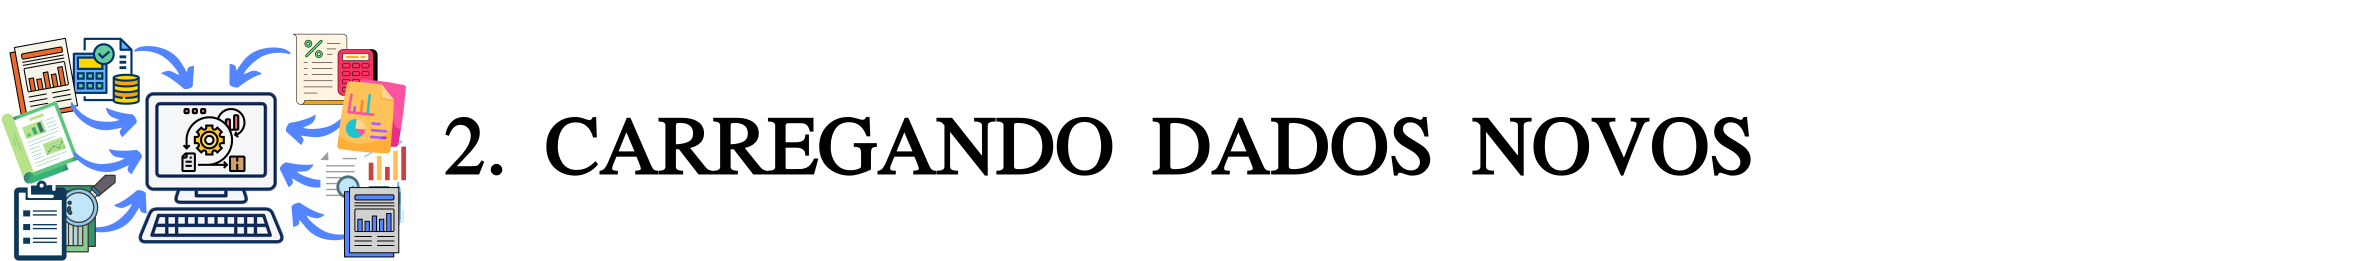

In [ ]:
# @title CARREGAR DADOS NOVOS E ANALISÁ-LOS (clique no botão PLAY abaixo)

# Verificando se o bloco de código de inicilaização foi executado
try:
  # Código de inicialização foi executado. Tentando carregar dados novos...
  try:
    # Fazendo upload do PDF e atribuindo seu nome para filename
    filename = next(iter(files.upload()))

    # Tentando minerar dados no PDF, classificar, salvar dados no Google Drive e
    # exibir relatório com os resultados da análise dos dados
    try:
      # Definido a flag para sinalizar que há dados novos carregados
      flag = 'new'
      splash.renderSplash('Extraindo dados do PDF<br>Aguarde...', 'info', delay=0)
      dh.miningDataInPDF(filename)
      dh.classifyAllReprov()
      dh.createReport()
      msg = '<u>Os dados foram carregados com sucesso! Mas observe</u>:<ol style="padding-left: 15px">'
      msg += '<li style = "padding-bottom: 10px">Para salvar os dados no seu Google Drive clique abaixo de'
      msg += ' SALVAR DADOS NO GOOGLE DRIVE</li><li>Para exibir o relatório da '
      msg += 'análise de dados clique abaixo de EXIBIR O RELATÓRIO</li></ol>'
      splash.renderSplash(msg, 'info', width=400, delay=5)
    except Exception as e:
      msg = '<div style="padding: 10px"><h3 style="text-align: center; color: '
      msg += 'white; text-decoration: underline">Algo errado aconteceu</h3>É '
      msg += 'provável que um dos itens abaixo tenha ocorrido:<ul><li>Você não '
      msg += 'clicou no botão PLAY de INICIALIZAÇÃO acima</li><li>Foi excedido'
      msg += ' o limite de uso da IA da Google</li><li>Alguma instabilidade no'
      msg += ' Google Gemini ocorreu. Tente novamente mais tarde</li></ul></div>'
      splash.renderSplash(msg, tipo='fail', align='justify', font_size=5, delay=10, width=400)
      dh.exception = e
  # Usuário interrompeu o carregamento de dados novos
  except (StopIteration, KeyboardInterrupt):
    pass

except Exception:
  import time
  from IPython.display import clear_output
  msg = 'Aplicação não foi inicializada\nClique no botão PLAY acima no tópico '
  msg += '"1. INICIALIZAÇÃO"'
  print(msg)
  time.sleep(5)
  clear_output()

In [27]:
# @title SALVAR DADOS NO GOOGLE DRIVE (clique no botão PLAY abaixo)

# Aplicação inicializada e dados novos foram carregados
try:
  if flag == 'new':

    # Tentando salvar os dados novos no Google Drive
    try:
      cod = dh.saveData()
      flag = 'saved'
      splash.renderSplash('Dados salvos com sucesso', 'sucess')
    # Algum erro aconteceu
    except Exception as e:
      msg = 'ALGO ERRADO ACONTECEU\nClique no primeiro botão PLAY acima e tente'
      msg += ' carregar os dados novamente. Se não conseguir, tente novamente '
      msg += 'mais tarde'
      splash.renderSplash(msg, 'fail')
      dh.exception = e

  # Não foram carregados dados novos
  else:
    splash.renderSplash('Não há dados novos para salvar', 'info')

# Aplicação não foi inicializada
except Exception:
  import time
  from IPython.display import clear_output
  msg = 'Aplicação não foi inicializada\nClique no botão PLAY acima no tópico '
  msg += '"1. INICIALIZAÇÃO"'
  print(msg)
  time.sleep(5)
  clear_output()

In [6]:
# @title EXIBIR O RELATÓRIO (clique no botão PLAY abaixo)

# Aplicação inicializada
try:
  if flag == 'new':
    files.download('/content/report.pdf')
  else:
    splash.renderSplash('Não foram carregados dados novos para gerar um relatório', 'info')

# Aplicação não foi inicializada
except Exception as e:
  import time
  from IPython.display import clear_output
  dh.exception = e
  msg = 'Aplicação não foi inicializada\nClique no botão PLAY acima no tópico '
  msg += '"1. INICIALIZAÇÃO"'
  print(msg)
  time.sleep(5)
  clear_output()

---
---
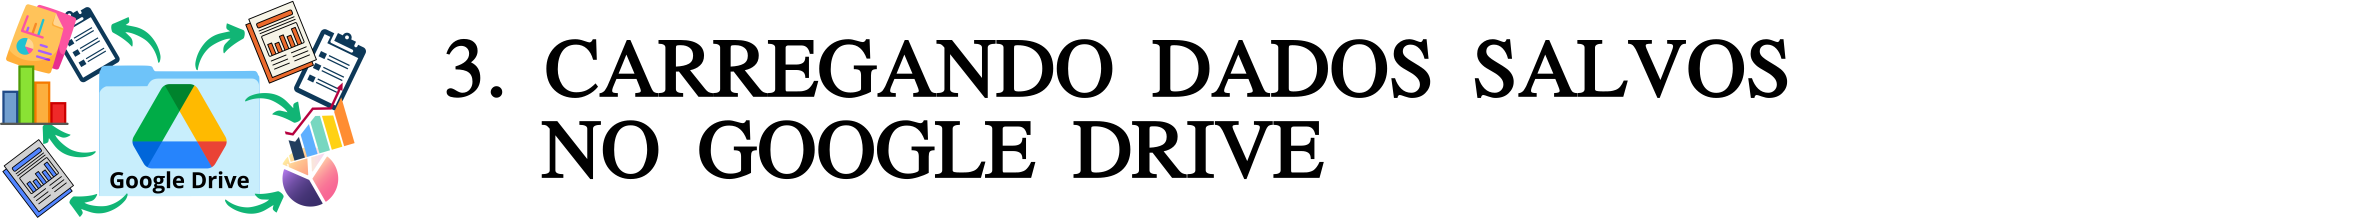

In [20]:
# @title CARREGAR DADOS SALVOS NO GOOGLE DRIVE (clique no botão PLAY abaixo)

# Aplicação foi inicializada
try:
  import ipywidgets as widgets

  # Definindo tabela HTML para opções
  elem_opcoes = '<h3 style="color: blue">Lista de dados salvos no Google Drive</h3>'
  elem_opcoes += """
  <table style='border-collapse: collapse; background-color: #e6f2ff'>
  <tr style='border: 1px solid black'>
    <td style='font-weight: bold; padding: 5px'>Opção</td>
    <td style='font-weight: bold; padding: 5px'>IPEM</td>
    <td style='font-weight: bold; padding: 5px'>Período analisado</td>
  </tr>
  """

  # Carregando os nomes das pastas de dados para a lista 'folders'
  lista = dh.loadListDataFolders()

  if len(lista) == 0:
    splash.renderSplash('Não há pastas aramazenadas no Google Drive', tipo='info')
  else:
    i = 0
    opcoes = []
    for item in lista:
      i += 1
      # Carregando o conteúdo do JSON da pasta atual
      with open(f'{dh.url_data_analysis}/{item["foldername"]}/metadata.json', 'r') as json_file:
        data = json.load(json_file)
      elem_opcoes += f"""
      <tr style='border: 1px solid black'>
        <td style='text-align: center; padding: 5px'>{i}</td>
        <td style='padding: 5px'>{data['ipem']}</td>
        <td style='padding: 5px'>{data['date_start']} a {data['date_end']}</td>
      </tr>
          """
      opcoes.append(item["foldername"])
    elem_opcoes += '</table><br>'
    display(HTML(elem_opcoes))
    print('')

    ###############################################################
    # Renderizando caixa de texto e botão para selecionar uma opção

    # Widget da caixa de texto (para a opção)
    text_box = widgets.Text(placeholder='Digite aqui a opção desejada', description='Opção:')

    # Widget do botão (para confirmar)
    button = widgets.Button(description='Confirmar', tooltip='Confirmar', icon='check')

    # Variável para armazenar a opção selecionada pelo usuário
    opcao = ''

    # Função para o evento onclik do botão, para armazenar o valor selecionado pelo
    # usuário para a variável 'opcao'
    def on_button_clicked(b):
      global opcao
      global opcoes
      global splash
      global dh
      global flag
      opcao = text_box.value
      if opcao.isdigit() and (int(opcao) - 1) in range(len(opcoes)):
        # Carregando dados da opção desejada
        opcao = int(opcao) - 1
        clear_output()
        splash.renderSplash('Carregando dados. Aguarde...', tipo='info', delay=0)
        dh.loadData(opcoes[opcao])
        dh.createReport()
        flag = 'up'
        clear_output()
        msg = 'Dados carregados com sucesso! Para exibir o relatório clique '
        msg += 'abaixo de EXIBIR O RELATÓRIO'
        splash.renderSplash(msg, tipo='sucess', width=350, delay=5)
      else:
        msg = 'Operação cancelada'
        splash.renderSplash(msg, tipo='info')
      clear_output()

    # Vinculando a função ao evento onclick do botão
    button.on_click(on_button_clicked)

    # HBox para organizar os widgets lado a lado
    widgets_layout = widgets.HBox([text_box, button])

    # Exibindo os widgets organizados no HBox
    display(widgets_layout)


# Aplicação não foi inicializada
except Exception:
  import time
  from IPython.display import clear_output
  msg = 'Aplicação não foi inicializada\nClique no botão PLAY acima no tópico '
  msg += '"1. INICIALIZAÇÃO"'
  print(msg)
  time.sleep(5)
  clear_output()

In [21]:
# @title EXIBIR O RELATÓRIO (clique no botão PLAY abaixo)

# A aplicação foi inicializada
try:
  if flag == 'up':
    files.download('/content/report.pdf')
  else:
    msg = 'Nenhum relatório foi gerado'
    splash.renderSplash(msg, tipo='info')

# A aplicação não foi inicializada
except Exception:
  import time
  from IPython.display import clear_output
  msg = 'Aplicação não foi inicializada\nClique no botão PLAY acima no tópico '
  msg += '"1. INICIALIZAÇÃO"'
  print(msg)
  time.sleep(5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
---